### モジュールとか関数とか

#### モジュール

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from pathlib import Path
import matplotlib.pyplot as plt
import lightgbm as lgb
import polars as pl
import pandas as pd
import numpy as np

#### 定数

In [3]:
TRAIN_DATA_PATH = Path('../../data/inputs/csv_files/train')
TEST_DATA_PATH = Path('../../data/inputs/csv_files/test')

print(TRAIN_DATA_PATH.exists(), TEST_DATA_PATH.exists())

True True


#### 関数

In [4]:
def read_file(dir_path: str, depth: int = 0) -> pd.DataFrame:
    df = pl.read_csv(dir_path)

    if depth == 1:
        df = df.group_by('case_id').max().drop('num_group1')
    elif depth == 2:
        df = df.group_by('case_id').max().drop(['num_group1', 'num_group2'])
    
    for col in df.columns:
        if col in ['case_id', 'WEEK_NUM', 'num_group1', 'num_group2']:
            df = df.with_columns(pl.col(col).cast(pl.Int64))
        elif col in ['date_decision']:
            df = df.with_columns(pl.col(col).cast(pl.Date))       
        elif col[-1] in ('P', 'A'):
            df = df.with_columns(pl.col(col).cast(pl.Float64))
        elif col[-1] in ('M'):
            df = df.with_columns(pl.col(col).cast(pl.String))
        elif col[-1] in ('D'):
            df = df.with_columns(pl.col(col).cast(pl.Date))       

    return df

In [5]:
def calc_auc_group(df: pd.DataFrame):
    y_pred = df['preds']
    y_true = df['target']
    return roc_auc_score(y_true, y_pred)

def plot_gini_metric(df: pd.DataFrame):
    df_auc = df.groupby('WEEK_NUM').apply(calc_auc_group, include_groups = False).reset_index()
    df_auc['gini'] = 2*df_auc[0] - 1
    reg = LinearRegression().fit(df_auc[['WEEK_NUM']], df_auc['gini'])
    reg_intercept = reg.intercept_
    reg_coef = reg.coef_[0]
    df_auc['gini_reg'] = reg_coef * df_auc['WEEK_NUM'] + reg_intercept
    final_score = df_auc['gini'].mean() + 88 * np.min([0, reg_coef]) - 0.5 * np.std(df_auc['gini'] - df_auc['gini_reg'])

    fig, ax = plt.subplots(figsize = (8, 6))
    ax.plot(df_auc['WEEK_NUM'], df_auc['gini'], marker = 'o', linewidth = 0)
    ax.plot(df_auc['WEEK_NUM'], df_auc['gini_reg'], color = 'k')
    ax.set_xlabel('WEEK_NUM', fontsize = 14)
    ax.set_ylabel('gini metric', fontsize = 14)
    ax.tick_params(axis = 'both', labelsize = 12)
    ax.text(0.1, 0.1, 'stability score: {:.2f}'.format(final_score), transform = ax.transAxes, fontsize = 18)

In [6]:
def plot_contamination(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize = (8, 6))
    df_0 = df[df['target'] == 0]
    df_1 = df[df['target'] == 1]

    ax.hist(df_0['preds'], alpha = 0.7, label = 'target = 0')
    ax.hist(df_1['preds'], alpha = 0.7, label = 'target = 1')
    ax.set_yscale('log')
    ax.legend(loc = 'best', fontsize = 12)

### データ処理とか

#### データ読み込み

In [7]:
file_names = {
    0: ['static_0', 'static_cb_0']
    ,1: ['applprev_1', 'credit_bureau_a_1', 'credit_bureau_b_1', 'debitcard_1', 'deposit_1', 'other_1', 'person_1', 'tax_registry_a_1', 'tax_registry_b_1', 'tax_registry_c_1']
    ,2: ['applprev_2', 'credit_bureau_a_2', 'credit_bureau_b_2', 'person_2']
}

#### データ結合

In [8]:
df_base = read_file(TRAIN_DATA_PATH / 'train_base.csv')

for depth in range(3):
    for ifn in file_names[depth]:
        for i, itrg in enumerate(TRAIN_DATA_PATH.glob(f'train_{ifn}*.csv')):
            if i == 0:
                tmp_df = read_file(itrg, depth)
            else:
                tmp_df = pl.concat([tmp_df, read_file(itrg, depth)], how = 'vertical_relaxed')
        df_base = df_base.join(tmp_df, how = 'left', on = 'case_id')

#### データ分割

In [9]:
df_base = df_base.to_pandas()

# 暫定で
drop_cols = [col for col in df_base.columns if df_base[col].dtypes not in ['int64', 'float64', 'bool']]
df_base = df_base.drop(drop_cols, axis = 1)

In [10]:
df_X = df_base.drop(['target', 'case_id', 'WEEK_NUM', 'MONTH'], axis = 1)
df_y = df_base['target']

### モデル構築

#### パラメータ設定

In [11]:
params = {
    'objective': 'binary'
    ,'boosting': 'gbdt'
    ,'random_state': 7
    #,'max_depth': 5
    #,'num_leaves': 31
    ,'min_data_in_leaf': 100
    ,'learning_rate': 0.1
    ,'force_row_wise': 'true'
}

num_splits = 5
kf = StratifiedKFold(n_splits = num_splits, shuffle = True, random_state = 7)

#### CVで学習

In [12]:
oof_preds = [[] for i in range(num_splits)]
boosters = []

for i, (itrain, ivalid) in enumerate(kf.split(df_X, df_y)):
    print('-' * 10, f'Fold {i + 1} Start ...', '-' * 10)
    d_lgb_train = lgb.Dataset(df_X.iloc[itrain], df_y.iloc[itrain])
    d_lgb_valid = lgb.Dataset(df_X.iloc[ivalid], df_y.iloc[ivalid])

    clf = lgb.train(
        params = params
        ,train_set = d_lgb_train
        ,valid_sets = d_lgb_valid
        ,num_boost_round = 10000
        ,callbacks = [
            lgb.early_stopping(100, verbose = True)
            ,lgb.log_evaluation(100)
        ]
    )

    valid_preds = clf.predict(df_X.iloc[ivalid], num_iteration = clf.best_iteration)
    oof_preds[i].append(ivalid)
    oof_preds[i].append(valid_preds)
    boosters.append(clf)

---------- Fold 1 Start ... ----------
[LightGBM] [Info] Number of positive: 38395, number of negative: 1182932
[LightGBM] [Info] Total Bins 38902
[LightGBM] [Info] Number of data points in the train set: 1221327, number of used features: 257
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031437 -> initscore=-3.427824
[LightGBM] [Info] Start training from score -3.427824
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.114843
[200]	valid_0's binary_logloss: 0.114104
[300]	valid_0's binary_logloss: 0.113917
[400]	valid_0's binary_logloss: 0.113846
[500]	valid_0's binary_logloss: 0.113775
[600]	valid_0's binary_logloss: 0.113805
Early stopping, best iteration is:
[506]	valid_0's binary_logloss: 0.113767
---------- Fold 2 Start ... ----------
[LightGBM] [Info] Number of positive: 38395, number of negative: 1182932
[LightGBM] [Info] Total Bins 38896
[LightGBM] [Info] Number of data points in the train set: 1221327, number of used features: 

KeyboardInterrupt: 

#### 結果を可視化

/var/folders/67/2x8gclcd0ngckwbgl5nfmzv00000gn/T/ipykernel_49178/4213284137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base_part['preds'] = oof_preds[i][1]
/var/folders/67/2x8gclcd0ngckwbgl5nfmzv00000gn/T/ipykernel_49178/4213284137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base_part['preds'] = oof_preds[i][1]
/var/folders/67/2x8gclcd0ngckwbgl5nfmzv00000gn/T/ipykernel_49178/4213284137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

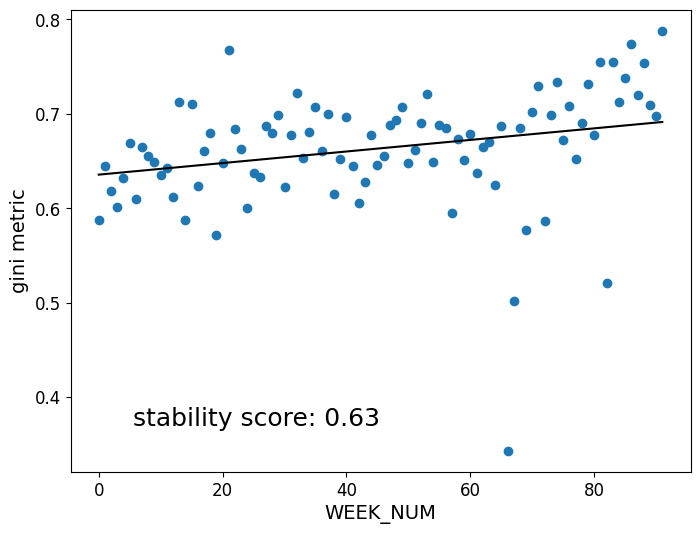

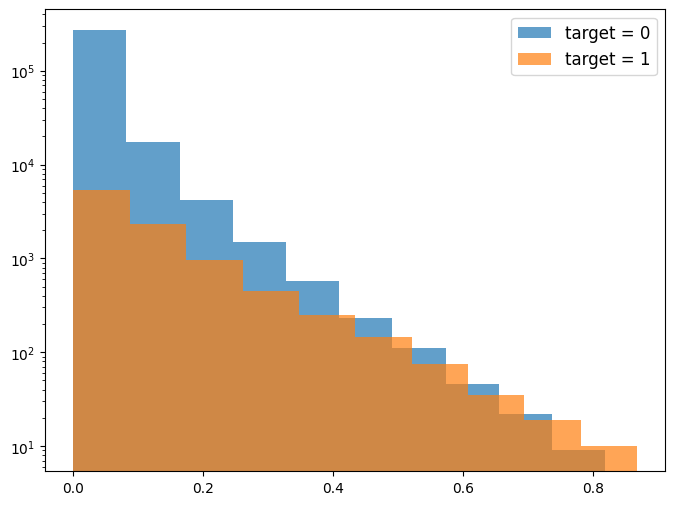

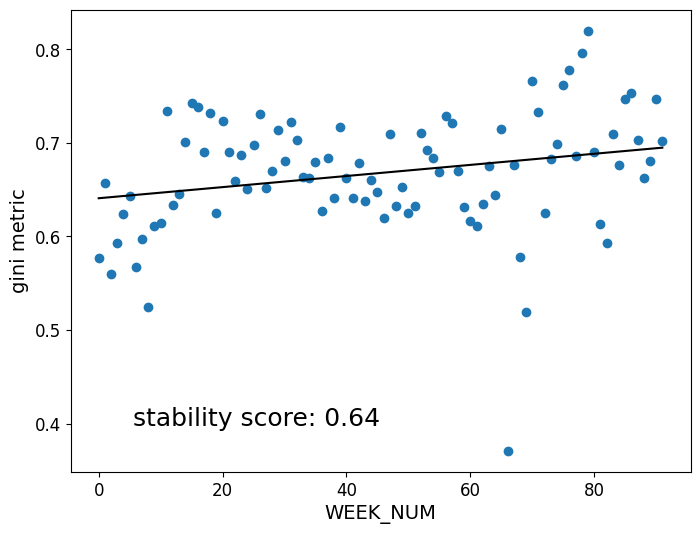

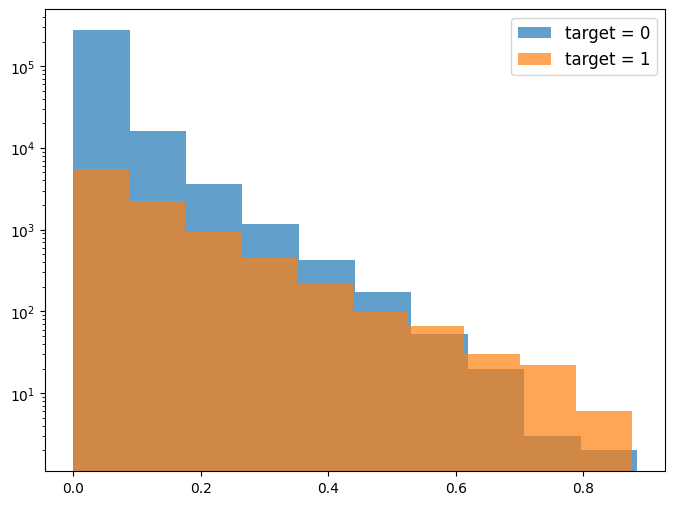

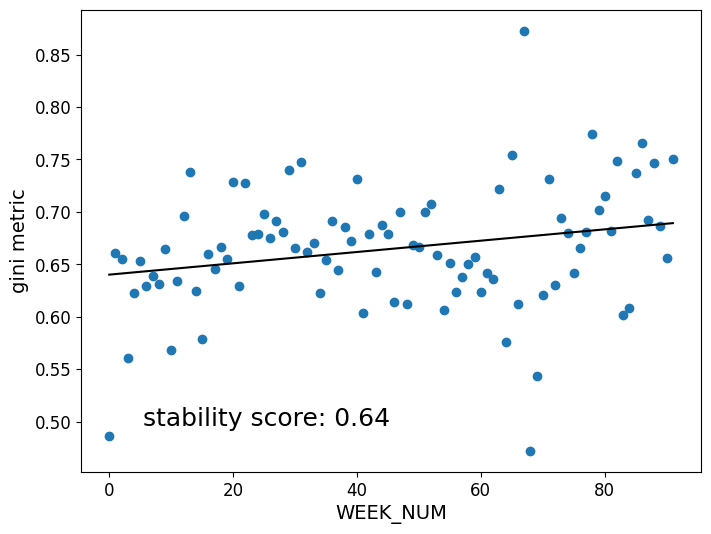

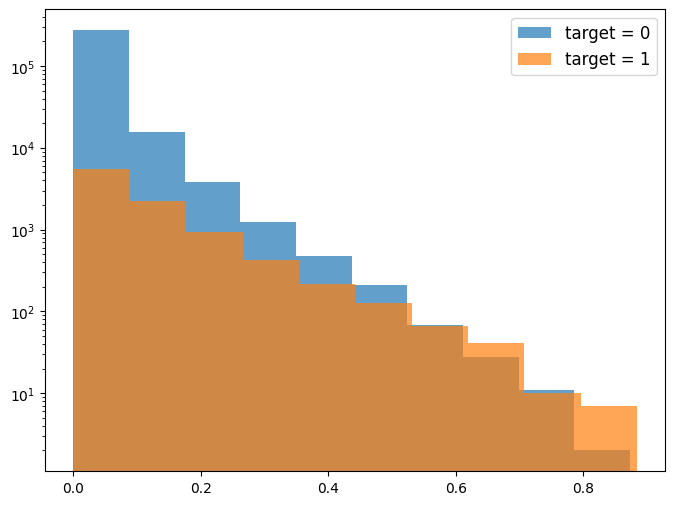

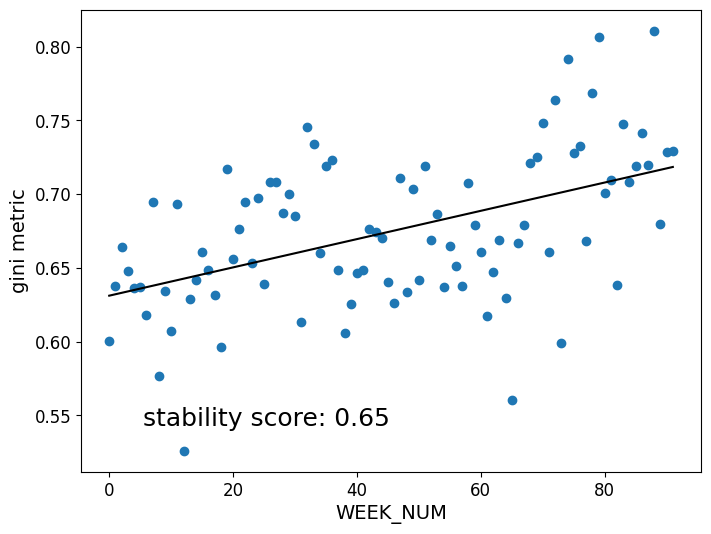

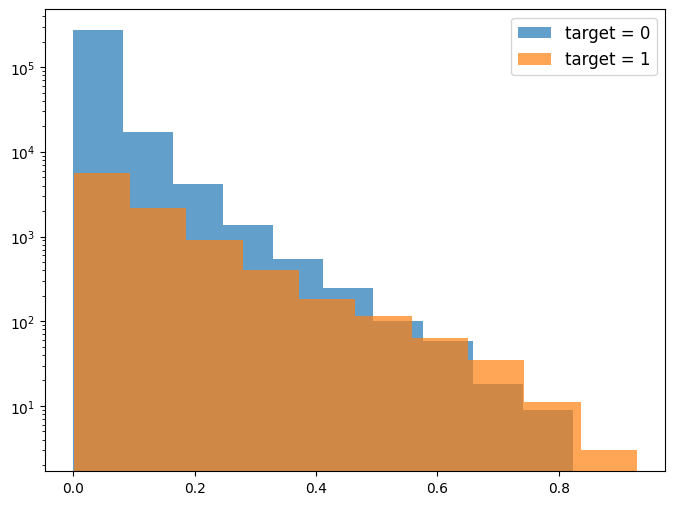

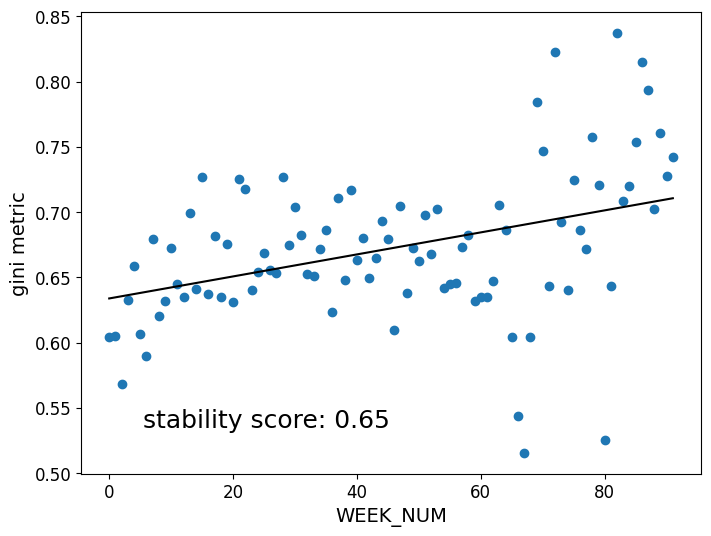

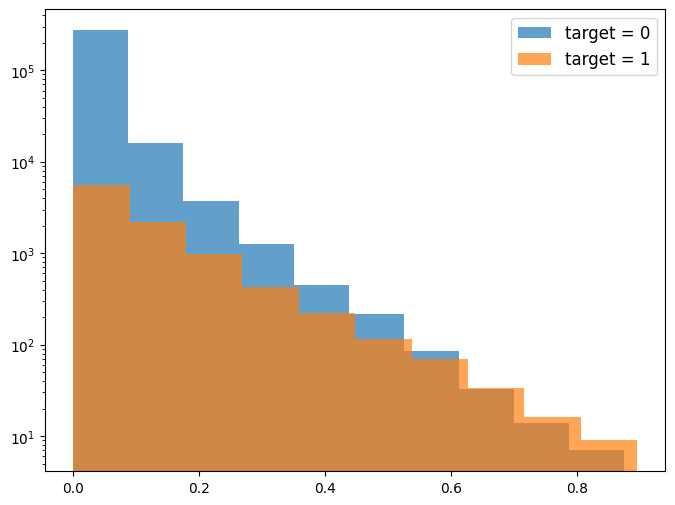

In [14]:
for i in range(len(oof_preds)):
    df_base_part = df_base.iloc[oof_preds[i][0]]
    df_base_part['preds'] = oof_preds[i][1]
    plot_gini_metric(df_base_part)
    plot_contamination(df_base_part)